In [54]:
%pylab inline
plt.style.use("bmh")
import pandas as pd
import numpy as np
import pathlib
import matplotlib as mpl


import datetime
from Estimator import forcast,retrieve_data,train

from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torch import optim,device,cuda

from ElectricityLoadDataset import ElectricityLoadDataset
from Models import MQRNN
from utils import quantile_loss


Populating the interactive namespace from numpy and matplotlib


In [20]:

DATA_DIR = pathlib.Path("data")
MODEL_DIR = pathlib.Path("models")
GRAPH_DIR = pathlib.Path("graphs")
device = device('cuda:0') if cuda.is_available() else device('cpu')

input_size = 1  # y
embed_size = 9 # x
hidden_size = 30  # for lstm: "both with a state dimension of 30"
context_size = 12  # for c_t/c_a
horizon = 24
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

samples = 100

batch_size = 32
random_seed = 42

print_every = 50
epochs = 2


In [8]:
data_loaders = retrieve_data(samples=samples)


In [9]:
model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)

train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)



Training info: samples=100, batch=32, printing training loss every 50*32=1600 samples
2021-03-05 19:09:07.974992 Starting epoch 1 / 2
2021-03-05 19:10:28.066182 t = 50, loss = 0.0874
2021-03-05 19:11:49.754939 t = 100, loss = 0.0844
2021-03-05 19:13:08.650929 t = 150, loss = 0.0606
2021-03-05 19:14:31.188192 t = 200, loss = 0.0505
2021-03-05 19:15:51.296392 t = 250, loss = 0.0812
2021-03-05 19:17:11.926869 t = 300, loss = 0.0665
2021-03-05 19:18:34.047365 t = 350, loss = 0.0484
2021-03-05 19:19:55.301999 t = 400, loss = 0.0625
2021-03-05 19:21:16.922647 t = 450, loss = 0.0433
2021-03-05 19:22:37.143043 t = 500, loss = 0.0402
2021-03-05 19:23:57.140037 t = 550, loss = 0.0427
2021-03-05 19:25:17.640751 t = 600, loss = 0.0401
2021-03-05 19:26:37.977833 t = 650, loss = 0.0463
2021-03-05 19:27:58.607150 t = 700, loss = 0.0405
2021-03-05 19:29:23.007713 t = 750, loss = 0.0347
2021-03-05 19:30:48.140592 t = 800, loss = 0.0406
2021-03-05 19:37:32.702564 Got average loss of (0.04)
2021-03-05 19

In [11]:
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()

In [46]:
GRAPH_DIR.joinpath(str(1))

WindowsPath('graphs/1')

In [59]:
from IPython.display import Image
img = GRAPH_DIR.joinpath(str(1))
Image(filename=img)


ValueError: Cannot embed the 'graphs\1' image format

In [43]:
eldata = pd.read_csv('data\LD2011_2014.txt',
                 parse_dates=[0],
                 delimiter=";",
                 decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)


eldata=eldata.resample('H', on='timestamp').mean().reset_index()


**Averaged over 370 households**

Only for values> 0.**

In [3]:
el_mean=eldata[eldata!=0].set_index("timestamp").mean(axis=1)


**An illustration of the winter-summer cycles**

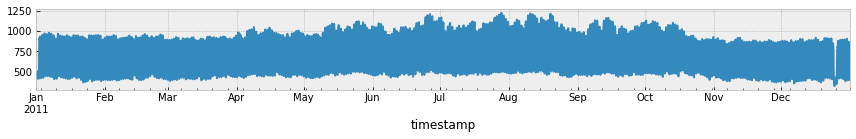

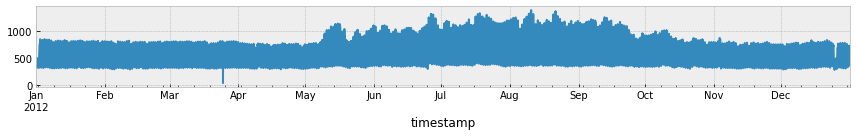

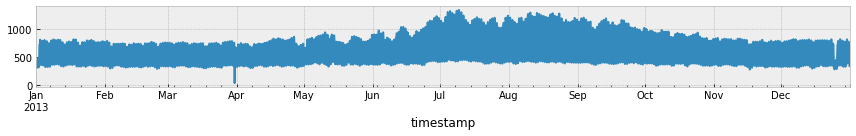

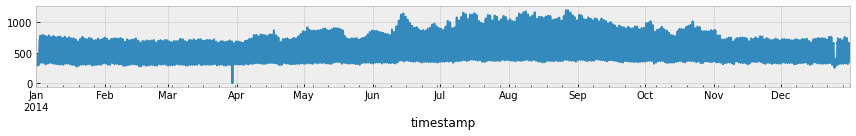

In [4]:

for year in ["2011","2012","2013","2014"]:
    plt.figure(figsize=(12,2))
    el_mean.loc[year].plot(ax=plt.gca())
    plt.tight_layout()
    plt.show()

Illustration of the yearly cycle. The cycle of peak consumption and minimum consumption is different.

To improve the predictive performance, we have added features of the general day/night cycle, day/night cycle for winter (in the summer is zero), and day and night cycle for summer  (in the winter is zero).

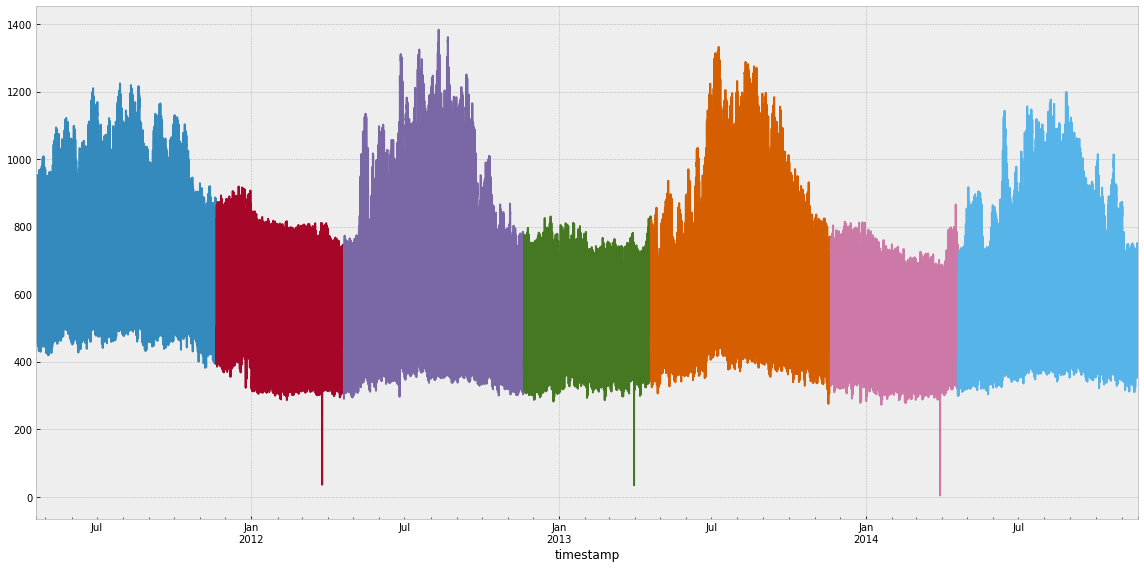

In [38]:
plt.figure(figsize=(16,8))
el_mean.loc["2011-1-1":"2011-4-19"].plot()
el_mean.loc["2011-4-20":"2011-11-19"].plot()
el_mean.loc["2011-11-20":"2012-4-19"].plot()
el_mean.loc["2012-4-20":"2012-11-19"].plot()

el_mean.loc["2012-11-20":"2013-4-19"].plot()
el_mean.loc["2013-4-20":"2013-11-19"].plot()

el_mean.loc["2013-11-20":"2014-4-19"].plot()
el_mean.loc["2014-4-20":"2014-11-19"].plot()
el_mean.loc["2014-11-20":"2015-1-31"].plot()


plt.tight_layout()

NOTE:
"Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points." 

Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.



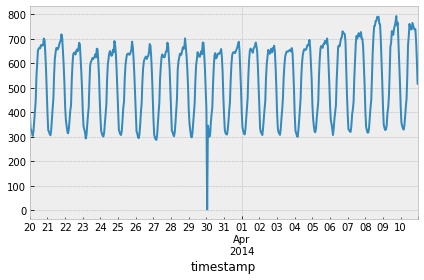

In [6]:
el_mean.loc["2014-3-20":"2014-4-10"].plot()

plt.tight_layout()

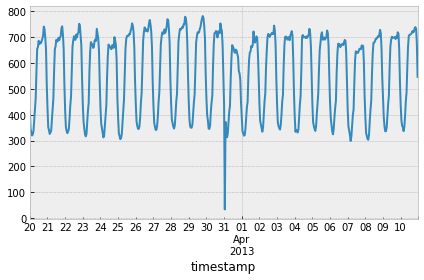

In [7]:
el_mean.loc["2013-3-20":"2013-4-10"].plot()

plt.tight_layout()



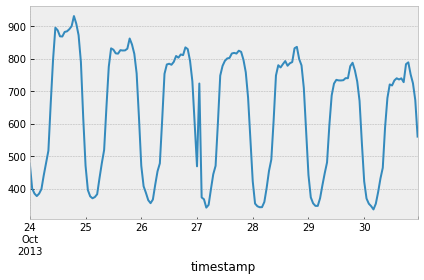

In [8]:
el_mean.loc["2013-10-24":"2013-10-30"].plot()

plt.tight_layout()


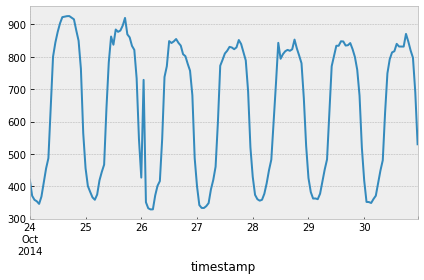

In [9]:
el_mean.loc["2014-10-24":"2014-10-30"].plot()

plt.tight_layout()
